## **1)** **Loading Dataset** from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import numpy as np
import pandas as pd

# Importing the Data file
data = pd.read_csv('/content/gdrive/MyDrive/SMIA/data.csv')
data = pd.read_csv('/content/gdrive/MyDrive/SMIA/data.csv')

# Preview Data
print("Size: ", len(data))
data.head()

Size:  416809


,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


(121187, 2)
(141067, 2)
(47712, 2)
(34554, 2)
(57317, 2)
(14972, 2)


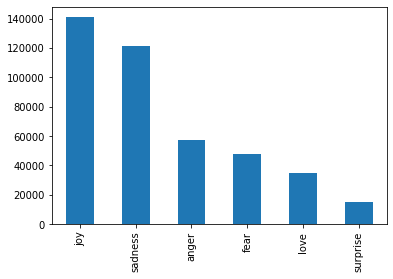

In [5]:
# Visualize the Samples
print(data[data['emotions']=='sadness'].shape)
print(data[data['emotions']=='joy'].shape)
print(data[data['emotions']=='fear'].shape)
print(data[data['emotions']=='love'].shape)
print(data[data['emotions']=='anger'].shape)
print(data[data['emotions']=='surprise'].shape)

# Plotting Graph
data.emotions.value_counts().plot.bar()

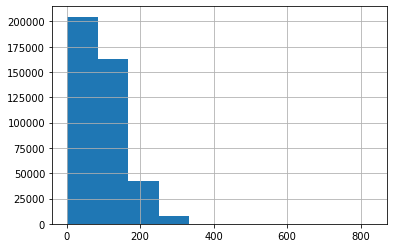

count    416809.000000
mean         97.028397
std          56.198232
min           2.000000
25%          54.000000
50%          86.000000
75%         128.000000
max         830.000000
dtype: float64

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# Analyzing Tweet Lengths
reviews = [len(x) for x in data['text']]
pd.Series(reviews).hist()
plt.show()

# Summarizing the Analysis
pd.Series(reviews).describe()

## **2) Data Preprocessing**

### Cleaning Text Data

In [31]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Removing Stopwords
nltk.download('stopwords')
stop_words = stopwords.words("english")

# Stemming text data
stemmer = SnowballStemmer("english")

# Removing Links, Users and Other Characters
regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
# Defining Cleaner Function
def cleaner(text, stem=False):
    text = re.sub(regex, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [33]:
# Applying Cleaner
data.text = data.text.apply(lambda x: cleaner(x))

# Preview Data
data.head()

,text,emotions
0,feel awful job get position succeed happen,sadness
1,im alone feel awful,sadness
2,ive probably mentioned really feel proud actua...,joy
3,feeling little low days back,sadness
4,beleive much sensitive peoples feelings tend c...,love


### Splitting Dataset

In [43]:
from sklearn.model_selection import train_test_split

trainData, testData = train_test_split(data, test_size=0.3, random_state=50)
print("Training set size:", len(trainData))
print("Testing set size:", len(testData))

Training set size: 291766
Testing set size: 125043


### Tokenizing Text

In [35]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Setting Up Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(trainData.text)
print("Total Unique Words: ", len(tokenizer.word_index) + 1)

Total Unique Words:  63686


In [36]:
# Applying Tokenizer
Max_Text_Length = 100

x_train = pad_sequences(tokenizer.texts_to_sequences(trainData.text), maxlen=Max_Text_Length)
x_test = pad_sequences(tokenizer.texts_to_sequences(testData.text), maxlen=Max_Text_Length)

### Encoding Labels

In [54]:
# Setting Up Label Encoder
Y = pd.get_dummies(data['emotions']).values

[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 1 0 0 0]
 ...
 [0 0 0 0 1 0]
 [0 0 1 0 0 0]
 [0 0 0 0 1 0]]


In [55]:
# Applying Label Encoder
y_train, y_test = train_test_split(Y, test_size=0.3, random_state=50)

In [56]:
# Checking Final Datasets
print("X Train Size: ", x_train.shape)
print("Y Train Size: ", y_train.shape)

print("X Test Size: ", x_test.shape)
print("Y Test Size: ", y_test.shape)

X Train Size:  (291766, 100)
Y Train Size:  (291766, 6)
X Test Size:  (125043, 100)
Y Test Size:  (125043, 6)


## **3) Emotion Detection** using LSTM and Word2Vec

### Embedding Layer using Word2Vec

In [71]:
import gensim

# Setting Up Word2Vec
w2v_Size = 100
w2v_Window = 7
w2v_Epoch = 32
w2v_Min_Count = 10

# Defining Word2Vec Model
w2v_model = gensim.models.word2vec.Word2Vec(size=w2v_Size, window=w2v_Window, min_count=w2v_Min_Count, workers=8)

In [72]:
# Building Vocabulary
documents = [text.split() for text in trainData.text] 
w2v_model.build_vocab(documents)
print("Vocabulary Size: ", len(w2v_model.wv.vocab.keys()) + 1)

Vocabulary Size:  12404


In [73]:
# Training Word2Vec Model
w2v_model.train(documents, total_examples=len(documents), epochs=w2v_Epoch)

(71112661, 87421248)

In [74]:
# Testing Sample
w2v_model.most_similar("kill")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('convince', 0.48107293248176575),
 ('killed', 0.4541497230529785),
 ('die', 0.443779855966568),
 ('scream', 0.44216063618659973),
 ('destroy', 0.4392930269241333),
 ('swallow', 0.4301959276199341),
 ('offend', 0.42926788330078125),
 ('throw', 0.4286537170410156),
 ('screw', 0.42799949645996094),
 ('yell', 0.4241545796394348)]

In [75]:
from keras.layers import Embedding

# Setting Up Embedding Layer
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_Size))

for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

embedding_layer = Embedding(vocab_size, w2v_Size, weights=[embedding_matrix], input_length=Max_Text_Length, trainable=False)

(63686, 100)


### Building and Compiling the Model

In [81]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout

# Defining Model Architecture
lstmModel = Sequential()

lstmModel.add(embedding_layer)
lstmModel.add(Dropout(0.5))

lstmModel.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstmModel.add(Dense(6, activation='softmax'))

print(lstmModel.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          6368600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 6,449,606
Trainable params: 81,006
Non-trainable params: 6,368,600
_________________________________________________________________
None


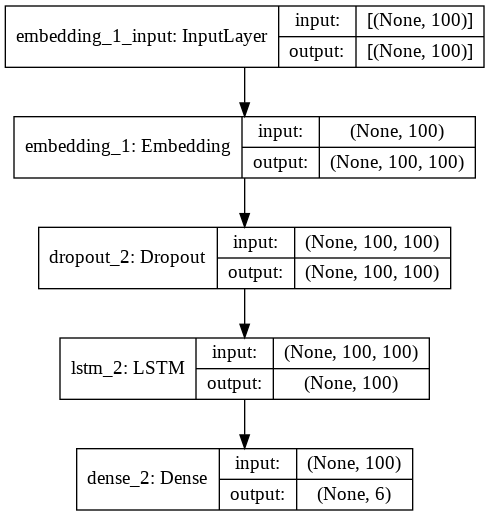

In [82]:
from keras.utils.vis_utils import plot_model

# Compiling the Model
lstmModel.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# Plotting Model Architecture
plot_model(lstmModel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training and Testing the Model

In [107]:
Batch_Size = 1024

In [84]:
modelScore = lstmModel.fit(x_train, y_train, batch_size=Batch_Size, epochs=3, validation_split=0.1, verbose=1)

Epoch 1/3
257/257 [==============================] - 592s 2s/step - loss: 1.2603 - accuracy: 0.5203 - val_loss: 0.3309 - val_accuracy: 0.8785
Epoch 2/3
257/257 [==============================] - 588s 2s/step - loss: 0.5976 - accuracy: 0.7780 - val_loss: 0.1765 - val_accuracy: 0.9274
Epoch 3/3
257/257 [==============================] - 592s 2s/step - loss: 0.4434 - accuracy: 0.8342 - val_loss: 0.1359 - val_accuracy: 0.9332


In [110]:
# Predicting the Test Data
y_pred = lstmModel.predict(x_test, verbose=1, batch_size=Batch_Size)

123/123 [==============================] - 58s 470ms/step


In [111]:
# Deciding Emotions on the predicted values
y_pred = np.array([[1 if x > 0.5 else 0 for x in y ] for y in y_pred])

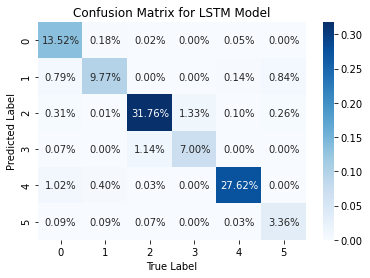

In [112]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sn.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title('Confusion Matrix for LSTM Model')
plt.show()

In [113]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

# Performance Measures
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='micro'))
print("AUC ROC:", roc_auc_score(y_test, y_pred, multi_class='ovr'))
print("Log Loss:", log_loss(y_test, y_pred))

Accuracy: 0.92648129043609
F1 Score: 0.9336078685776683
AUC ROC: 0.9497932414651838
Log Loss: 2.039305807500512


## **4) Emotion Detection** using LSTM and custom EMBD Layer

### Building and Compiling the Model

In [159]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

# Defining Model Architecture
nnModel = Sequential()

nnModel.add(Embedding(63686, 64, input_length = x_train.shape[1]))
nnModel.add(SpatialDropout1D(0.4))

nnModel.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
nnModel.add(Dense(6, activation='softmax'))

print(nnModel.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 64)           4075904   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 64)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 4,109,318
Trainable params: 4,109,318
Non-trainable params: 0
_________________________________________________________________
None


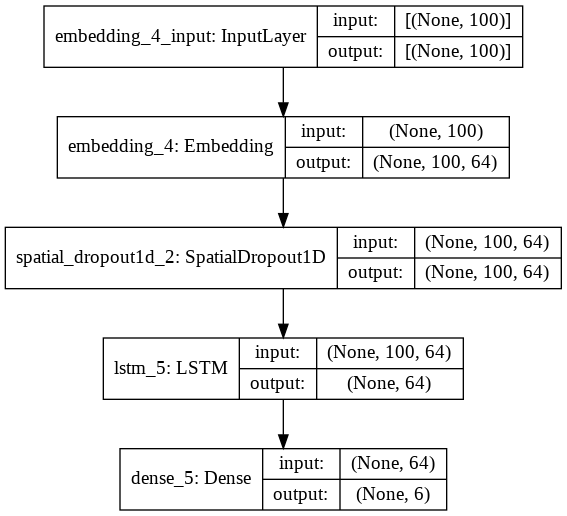

In [160]:
from keras.utils.vis_utils import plot_model

# Compiling the Model
nnModel.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

# Plotting Model Architecture
plot_model(nnModel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training and Testing the Model

In [161]:
Batch_Size = 1024

In [122]:
modelScore = nnModel.fit(x_train, y_train, batch_size=Batch_Size, epochs=3, validation_split=0.1, verbose=1)

Epoch 1/3
257/257 [==============================] - 368s 1s/step - loss: 1.3149 - accuracy: 0.4954 - val_loss: 0.2319 - val_accuracy: 0.9074
Epoch 2/3
257/257 [==============================] - 371s 1s/step - loss: 0.2249 - accuracy: 0.9149 - val_loss: 0.1512 - val_accuracy: 0.9208
Epoch 3/3
257/257 [==============================] - 369s 1s/step - loss: 0.1443 - accuracy: 0.9339 - val_loss: 0.1228 - val_accuracy: 0.9272


In [123]:
# Predicting the Test Data
y_pred = nnM.predict(x_test, verbose=1, batch_size=Batch_Size)

123/123 [==============================] - 31s 250ms/step


In [124]:
# Deciding Emotions on the predicted values
y_pred = np.array([[1 if x > 0.5 else 0 for x in y ] for y in y_pred])

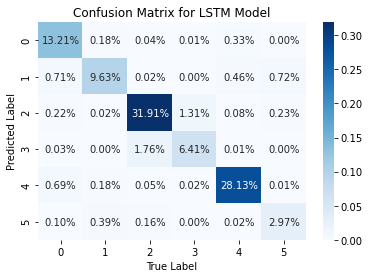

In [125]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sn.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title('Confusion Matrix for LSTM Model')
plt.show()

In [126]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

# Performance Measures
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='micro'))
print("AUC ROC:", roc_auc_score(y_test, y_pred, multi_class='ovr'))
print("Log Loss:", log_loss(y_test, y_pred))

Accuracy: 0.9200594995321609
F1 Score: 0.9245661337180101
AUC ROC: 0.9330834598015311
Log Loss: 2.441807979743934


## **5) Emotion Detection** using other models

### Required Preprocessing 

In [135]:
from sklearn.preprocessing import StandardScaler

# Scaling the Data
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

(291766, 100)


In [146]:
# Reshaping the Data
Y_train=y_train
Y_test=y_test

### Random Forest Classifier

In [156]:
from sklearn.ensemble import RandomForestClassifier

# Defining Model
model = RandomForestClassifier()

# Training Model
model.fit(X_train, Y_train)

# Predicting Results
y_pred = model.predict(X_test)

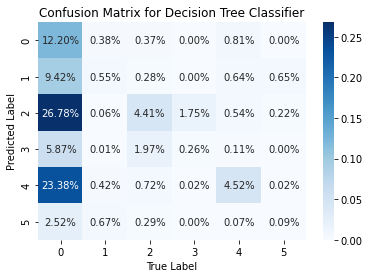

In [157]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
sn.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

In [158]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

# Performance Measures
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("F1 Score:", f1_score(Y_test, y_pred, average='micro'))
print("AUC ROC:", roc_auc_score(Y_test, y_pred, multi_class='ovr'))
print("Log Loss:", log_loss(Y_test, y_pred))

Accuracy: 0.10708316339179322
F1 Score: 0.17569757448120663
AUC ROC: 0.5256760227590166
Log Loss: 5.263154217142652


### Decision Tree Classifier

In [97]:
from sklearn.tree import DecisionTreeClassifier

# Defining Model
model = DecisionTreeClassifier()

# Training Model
model.fit(X_train, Y_train)

# Predicting Results
y_pred = model.predict(X_test)

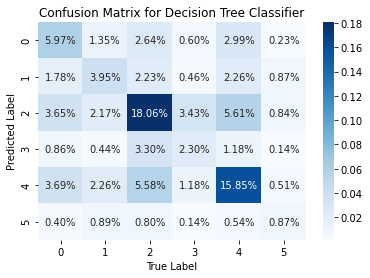

In [99]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
sn.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

In [100]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

# Performance Measures
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("F1 Score:", f1_score(Y_test, y_pred, average='micro'))
print("AUC ROC:", roc_auc_score(Y_test, y_pred, multi_class='ovr'))
print("Log Loss:", log_loss(Y_test, y_pred))

Accuracy: 0.4661996273281991
F1 Score: 0.4729683132730511
AUC ROC: 0.6406778468591444
Log Loss: 17.499521550430494


## **Others**

### Tokenizer: Saving and Loading

In [62]:
import pickle

# Setting Up Path
tokenizer_Path = '/content/gdrive/MyDrive/SMIA/tokenizer.pkl'

In [65]:
# Loading Tokenizer
tokenizer = pickle.load(open(tokenizer_Path, "rb"))

In [64]:
# Saving Tokenizer
pickle.dump(tokenizer, open(tokenizer_Path, "wb"), protocol=0)

### Word2Vec: Saving and Loading

In [66]:
# Setting Up Path
w2v_Path = '/content/gdrive/MyDrive/SMIA/w2vModel.w2v'

In [68]:
# Loading the Model
w2v_model = gensim.models.Word2Vec.load(w2v_Path)

In [76]:
# Saving the Model
w2v_model.save(w2v_Path)

### LSTM Model: Saving and Loading

In [85]:
# Setting Up Path
lstm_Path = '/content/gdrive/MyDrive/SMIA/lstmModel.h5'

In [ ]:
from tensorflow.keras.models import load_model

# Loading the Model
lstmModel = load_model(lstm_Path)

In [86]:
# Saving the Model
lstmModel.save_weights(lstm_Path)

### NN Model: Saving and Loading

In [136]:
# Setting Up Path
nnModel_Path = '/content/gdrive/MyDrive/SMIA/nnModel.h5'

In [ ]:
from tensorflow.keras.models import load_model

# Loading the Model
nnModel = load_model(nnModel_Path)

In [138]:
# Saving the Model
nnModel.save_weights(nnModel_Path)